**DSND Capstone Poject: Code Snippet Classification**

In this project, we plan to classify code snippets into selected set of programming languages from Stackoverflow. The dataset for this project is extracted from Stackoverflow for the following programming languages: 

1. PHP
2. Ruby
3. HTML
4. C#
5. C++
6. Javascript 
7. Swift 
8. SQL 
9. Perl
10. Python 

This project address many real challanges such as Codes tagging in platforms such as Github or Stackoverflow. 

In [22]:
import pandas as pd 
import numpy as np 
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
import time
from sklearn.metrics import classification_report,accuracy_score

***Load the dataset***

In [2]:
php_df = pd.read_csv('php.csv')
sql_df = pd.read_csv('sql.csv')
cPLusPlus_df = pd.read_csv('c++.csv')
cSharp_df = pd.read_csv('c#.csv')
html_df = pd.read_csv('html.csv')
javascript_df = pd.read_csv('javascript.csv')
ruby_df = pd.read_csv('ruby.csv')
python_df = pd.read_csv('python.csv')
swift_df = pd.read_csv('swift.csv')
perl_df = pd.read_csv('perl.csv')

**Clean the data and tags**

The first step of the work is cleanup the data and remove the unncessary texts and remove additional tags.

In [3]:
def cleanData(df,lang):
    df['Tags'] = lang
    df['Body'] = df['Body'].str.replace('&lt;',' ')
    df['Body'] = df['Body'].str.replace('&gt;',' ')
    df['Body'] = df['Body'].str.replace('\n',' ')
    df['Body'] = df['Body'].str.replace('"',' ')
    df['Body'] = df['Body'].str.replace(';','')
    df['Body'] = df['Body'].str.replace('$','')
    df['Body'] = df['Body'].str.replace('=',' ')
    df['Body'] = df['Body'].str.replace(',','')
    df['Body'] = df['Body'].str.replace('.',' ')
    df['Body'] = df['Body'].str.replace(':',' ')
    df['Body'] = df['Body'].str.replace('(',' ')
    df['Body'] = df['Body'].str.replace(')',' ')
    df['Body'] = df['Body'].str.replace('}',' ')
    df['Body'] = df['Body'].str.replace('{',' ')  
    df['Body'] = df['Body'].str.replace('\d+', ' ') # remove digits
    
    for index, row in df.iterrows():
        find_index = 0 
        body = row['Body']
        final_body = ""
        while find_index < len(body):
            code = body.find('<code>',find_index)+6
            end_code = body.find('</code>',find_index)
            if code != -1 and end_code != -1:
                final_body += body[code:end_code] + " "
                find_index = end_code+7
            else:
                break
        final_body = final_body.replace('>','')
        final_body = final_body.strip()
        final_body = re.sub(' +', ' ',final_body)
        if len(final_body) != 0:
            df.loc[index, 'Body'] = final_body
    print(lang, 'has been processed ')
    return df

In [4]:
php_df = cleanData(php_df,'php')
sql_df = cleanData(sql_df,'sql')
cPLusPlus_df = cleanData(cPLusPlus_df,'c++')
cSharp_df = cleanData(cSharp_df,'c#')
html_df = cleanData(html_df,'html')
javascript_df = cleanData(javascript_df,'javascript')
ruby_df = cleanData(ruby_df,'ruby')
python_df = cleanData(python_df,'python')
swift_df = cleanData(swift_df,'swift')
perl_df = cleanData(perl_df,'perl')

php has been processed 
sql has been processed 
c++ has been processed 
c# has been processed 
html has been processed 
javascript has been processed 
ruby has been processed 
python has been processed 
swift has been processed 
perl has been processed 


**Merge all Datasets**

In [6]:
final_df = pd.DataFrame()
final_df = final_df.append([sql_df,html_df,php_df,ruby_df,swift_df,cSharp_df,perl_df,javascript_df,cPLusPlus_df,python_df], ignore_index=True)
final_df['code_length']  = final_df['Body'].str.len()
final_df.describe()

,code_length
count,200000.000000
mean,686.897110
std,1198.438656
min,1.000000
25%,145.000000
50%,344.000000
75%,755.000000
max,25137.000000


**Remove Outliers**

In [7]:
trimmed_df = final_df[(final_df['code_length'] > 50 ) & (final_df['code_length'] < 1000)]
trimmed_df.describe()

,code_length
count,147241.000000
mean,359.791064
std,245.219108
min,51.000000
25%,156.000000
50%,297.000000
75%,518.000000
max,999.000000


***Save the processed result***

In [8]:
trimmed_df.to_pickle("processed_data.pkl")

***Data Exploration***

Analyze the number of samples by Programming Language 

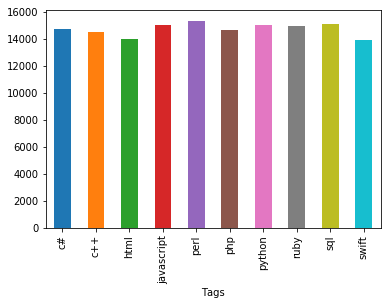

In [10]:
trimmed_df.groupby(by='Tags')['Body'].count().plot(kind='bar')

After processing the data, we are left with somewhat balanced data for each language. 

Analyze the code length by programming Language

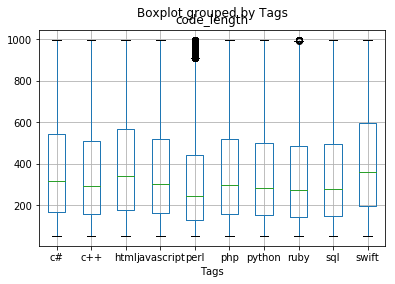

In [11]:
trimmed_df.boxplot(column=['code_length'], by='Tags')

The median length for each code snippet per language is between 200 char and 400 char 

In [12]:
trimmed_df.sample(10)

,Body,Tags,code_length
30830,React Component new render !DOCTYPE html html ...,html,843
141336,var ContractWindow function showContract Contr...,javascript,345
80259,override func prepare for segue UIStoryboardSe...,swift,697
158372,insertRow insertCell function tabappend player...,javascript,553
102004,private Image GridMap private double ZoomFacto...,c#,315
141533,script type text/template id commentsTemplate ...,javascript,169
68555,rails g migration AddEntreeToVenue entree belo...,ruby,304
30334,HTTP Content-Type of video/ gpp is not support...,html,182
159357,for var i i this bucket_names length i++ if th...,javascript,474
23828,string html using var client new WebClient htm...,html,436


***Features Engineering***

In [13]:
def to_tfidf_list(feature_text_list):
    tfidf_vector = TfidfVectorizer(max_features=1000,ngram_range =(1,2),lowercase=True,stop_words='english',use_idf=True)
    train_tfidf = tfidf_vector.fit_transform(feature_text_list)    
    return ( train_tfidf , tfidf_vector )

def transform_tfidf(test_text, tfidf_vector):
    test_tfidf = tfidf_vector.transform(test_text)
    return test_tfidf

def prepareData(texts, classes_dict):

    train_texts,test_texts,train_classes, test_classes = train_test_split(texts,classes_dict,test_size=0.33,random_state=42)
    train_tfidf, vect_trans = to_tfidf_list(train_texts)
    test_tfidf = transform_tfidf(test_texts, vect_trans)
    print("Training Size: ",train_texts.shape)
    print("Test Size: ",test_texts.shape)    
    
    return vect_trans,train_tfidf,test_tfidf,train_classes, test_classes

In [16]:
texts = trimmed_df['Body']
classes_dict = trimmed_df['Tags']

vect_trans,train_tfidf,test_tfidf,train_classes, test_classes = prepareData(texts, classes_dict)

Training Size:  (98651,)
Test Size:  (48590,)


In [ ]:
vect_trans.get_feature_names()

***Prepare the classifier to use***

In [50]:
def getClassifier():
    clf1 = MultinomialNB()
    clf2 = LinearSVC(C=2)
    #clf3 = LogisticRegression(C=32)
    #clf = VotingClassifier(estimators=[('mb',clf1),('lsvc',clf2),('lr',clf3)]);
    return clf2

clf = getClassifier()

In [51]:
def train(clf, train_tfidf, train_classes):
    mid_start_time = time.time()
    clf.fit(train_tfidf, train_classes)
    print("Training: Done in %f seconds" % (time.time() - mid_start_time))
    
def predict(clf, test_tfidf):
    test_pred = clf.predict(test_tfidf)
    return test_pred

***Train the Classifier***

In [52]:
train(clf,train_tfidf, train_classes)

Training: Done in 13.005526 seconds


***Predict on the Testing Data***

In [53]:
test_pred = predict(clf, test_tfidf)

***Evaluate The Result of the Model***

To evaulate the model, we will look at the precision, recall and f1-score

In [54]:
print("Accuracy: ", accuracy_score(test_classes, test_pred))

Accuracy:  0.7163819715990944


In [55]:
print(classification_report(test_classes, test_pred))

              precision    recall  f1-score   support

          c#       0.70      0.76      0.73      4832
         c++       0.85      0.85      0.85      4817
        html       0.56      0.59      0.58      4602
  javascript       0.59      0.60      0.60      4936
        perl       0.70      0.67      0.68      5144
         php       0.66      0.59      0.62      4977
      python       0.76      0.79      0.78      4940
        ruby       0.82      0.76      0.79      4855
         sql       0.64      0.69      0.66      4932
       swift       0.90      0.88      0.89      4555

   micro avg       0.72      0.72      0.72     48590
   macro avg       0.72      0.72      0.72     48590
weighted avg       0.72      0.72      0.72     48590



***Save the Model For Prediction***

In [57]:
from sklearn.externals import joblib
joblib.dump(vect_trans, "tfidfVectorizer.pkl")
joblib.dump(clf, "classifier.pkl")

['classifier.pkl']

### Conculsion 

From the result above, we have came a long way to predict code snippet language. Because of the nature of Stackoverflow dataset where a question can have multiple code snippets from multiple languages it become diffcult to pick just own language.